In [118]:
max_pocessing = 15 ## Set this value for the amount of maximum rows you want to process. Google Scholar has quite a few researchers

In [119]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

driver = webdriver.Firefox()
driver.get("https://scholar.google.de/citations?view_op=view_org&hl=en&org=15309337599806254000")

In [120]:
def get_researchers():
    researchers = []
    elems = driver.find_elements(by=By.XPATH,value="//h3[@class='gs_ai_name']/a")
    for elem in elems:
      f,*m,l = elem.text.split(" ")
      researchers.append([f,m,l])
    return researchers

In [121]:
btn = driver.find_element(by=By.XPATH,value='//button[@class="gs_btnPR gs_in_ib gs_btn_half gs_btn_lsb gs_btn_srt gsc_pgn_pnx"]')
researchers = []
while btn:
    if len(researchers) >= max_pocessing:
        break
    researchers += get_researchers()
    btn.click()
    btn = driver.find_element(by=By.XPATH,value='//button[@class="gs_btnPR gs_in_ib gs_btn_half gs_btn_lsb gs_btn_srt gsc_pgn_pnx"]')   


In [122]:
driver.close()

In [123]:
import pandas as pd
df = pd.DataFrame(researchers, columns=['name', 'middle_name', 'last_name'])


In [124]:
import requests
from bs4 import BeautifulSoup
my_url = "https://www.gpeters.com/names/baby-names.php"
my_header = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:101.0) Gecko/20100101 Firefox/101.0"}

In [125]:
def lookup_name(row:pd.Series)->pd.Series:
    request_url = f"{my_url}?name={row['name']}"
    content = requests.get(url=request_url,headers=my_header).content
    soup = BeautifulSoup(content,"html.parser")
    try:
        row["gender_result"] = "female" if "girl" in soup.find("div",{"class": "gender-result"}).find("h1").contents[0] else "male"
    except Exception as e:
        row["gender_result"] = "error"
        return row
    number_of_results=len(soup.find("div",{"class": "gender-result"}).find_all("p"))
    try:
        if number_of_results == 1:
            row["likelyhood_result"] = None
            row["popularity_result"] = float(soup.find("div",{"class": "gender-result"}).find_all("p")[0].contents[0].split(" ")[5])
        elif number_of_results == 2:
            row["likelyhood_result"] = float(soup.find("div",{"class": "gender-result"}).find_all("p")[0].contents[0].split(" ")[6])
            row["popularity_result"] = float(soup.find("div",{"class": "gender-result"}).find_all("p")[1].contents[0].split(" ")[5])
    except Exception as e:
        row["gender_result"] = "error"
    return(row)

In [127]:
results_df = df.head(max_pocessing).apply(lookup_name, axis=1)

male     0.933333
error    0.066667
Name: gender_result, dtype: float64


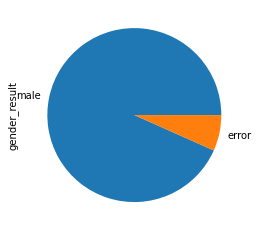

In [128]:
results_df["gender_result"].value_counts(normalize=True).plot(kind="pie")
print(results_df["gender_result"].value_counts(normalize=True))